In [1]:
import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
import pandas as pd
import numpy as np
import glob, os

import itertools

from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage
from IPython.core.display import display, HTML

import statsmodels.tsa.api as smt
import statsmodels.tsa.filters as smfilters

import plotly.plotly as py  
import plotly.tools as tls   
import plotly.graph_objs as go

import pandas as pd
import numpy as np
import scipy
import pprint

%pylab inline
figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)
pp = pprint.PrettyPrinter(indent=4)

exo_list = storage.exo_list()
pp.pprint(exo_list)


df = pd.DataFrame()

for e in exo_list:
    exo_series, exo_dict = storage.load_series(e)
    
    exo_series = exo_series[exo_series.columns[0]]
    df[exo_dict['name']] = exo_series
#exo_series.plot()

[   'ES_BullishCollarBW',
    'ES_BearishCollarBW',
    'ES_CallSpread',
    'ES_PutSpread',
    'ES_ContFut',
    'ZS_BullishCollarBW',
    'ZS_BearishCollarBW',
    'ZS_CallSpread',
    'ZS_PutSpread',
    'ZS_ContFut',
    'CL_BullishCollarBW',
    'CL_BearishCollarBW',
    'CL_CallSpread',
    'CL_PutSpread',
    'CL_ContFut',
    'ZW_BullishCollarBW',
    'ZW_BearishCollarBW',
    'ZW_CallSpread',
    'ZW_PutSpread',
    'ZW_ContFut',
    'ZN_BullishCollarBW',
    'ZN_BearishCollarBW',
    'ZN_CallSpread',
    'ZN_PutSpread',
    'ZN_ContFut',
    'NG_BullishCollarBW',
    'NG_BearishCollarBW',
    'NG_CallSpread',
    'NG_PutSpread',
    'NG_ContFut',
    'ZC_BullishCollarBW',
    'ZC_BearishCollarBW',
    'ZC_CallSpread',
    'ZC_PutSpread',
    'ZC_ContFut',
    'CL_SMART_Ichimoku_Long',
    'ES_SMART_Ichimoku_Long',
    'NG_SMART_Ichimoku_Long',
    'ZC_SMART_Ichimoku_Long',
    'ZS_SMART_Ichimoku_Long',
    'ZW_SMART_Ichimoku_Long',
    'ZN_SMART_Ichimoku_Long']


In [3]:
df.tail()

,ES_BullishCollarBW,ES_BearishCollarBW,ES_CallSpread,ES_PutSpread,ES_ContFut,ZS_BullishCollarBW,ZS_BearishCollarBW,ZS_CallSpread,ZS_PutSpread,ZS_ContFut,...,ZC_CallSpread,ZC_PutSpread,ZC_ContFut,CL_SMART_Ichimoku_Long,ES_SMART_Ichimoku_Long,NG_SMART_Ichimoku_Long,ZC_SMART_Ichimoku_Long,ZS_SMART_Ichimoku_Long,ZW_SMART_Ichimoku_Long,ZN_SMART_Ichimoku_Long
2016-10-19,9531.660534,-41001.291316,9531.308724,-12710.610390,49337.5,-43071.537719,43559.217026,5697.356810,-6588.087318,-16562.5,...,NaN,NaN,NaN,-917430.0,212075.0,-283750.0,-121837.5,304725.0,-339087.5,134531.25
2016-10-20,9320.675456,-40951.696070,9466.065313,-12681.115296,49062.5,6092.562556,-5432.134074,7787.514517,-5480.843389,32300.0,...,-10079.641502,3951.533085,-5812.5,-936330.0,209825.0,-288550.0,-121837.5,304662.5,-339087.5,134531.25
2016-10-21,9213.422255,-41016.455457,9452.035709,-12682.375122,49025.0,6247.980145,-5581.312250,7923.205480,-5601.403427,32500.0,...,-10092.275969,3948.652572,-5812.5,-937530.0,209825.0,-291250.0,-122212.5,304100.0,-339650.0,134531.25
2016-10-23,9218.989729,-41089.414416,9462.114559,-12695.136858,49100.0,6339.642296,-5680.018307,8007.304112,-5684.192799,32637.5,...,-10082.491324,3923.741937,-5787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-24,9400.754619,-41349.361183,9566.190872,-12774.479192,49525.0,6798.757461,-6116.161950,8479.472356,-5998.764381,33212.5,...,-10231.316875,4026.023728,-5987.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
px_ser = df.ES_CallSpread.dropna()
#px_ser = (px_ser - px_ser.ewm(2).mean()).dropna()

sd = smt.seasonal_decompose(px_ser.asfreq('B').ffill().dropna().iloc[:])#.plot()

resid = sd.resid

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



NameError: name 'fixed_hpfilt' is not defined

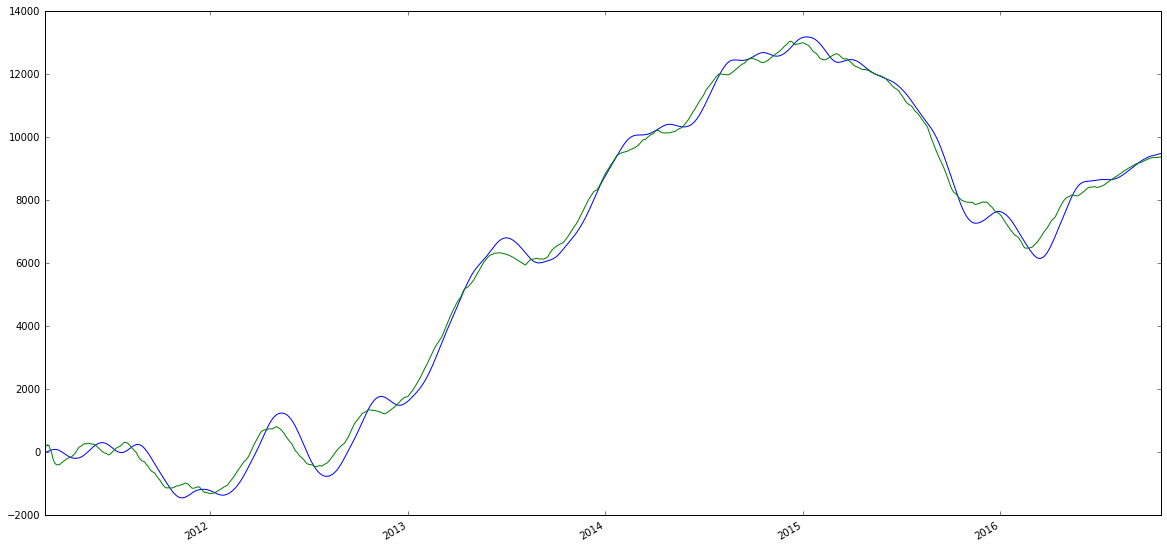

In [7]:
#px_ser.plot()

px_ser.ewm(10).mean().ewm(10).mean().ewm(10).mean().ewm(10).mean().ewm(10).mean().plot()
px_ser.ewm(50).mean().plot()
fixed_hpfilt.plot()
#px_ser.ewm(10).mean().ewm(10).mean().plot()
#px_ser.ewm(10).mean().ewm(10).mean().ewm(10).mean().plot()
#px_ser.ewm(10).mean().ewm(10).mean().ewm(10).mean().ewm(10).mean().plot()
#px_ser.rolling(50, center=True, win_type='blackmanharris').mean().plot()

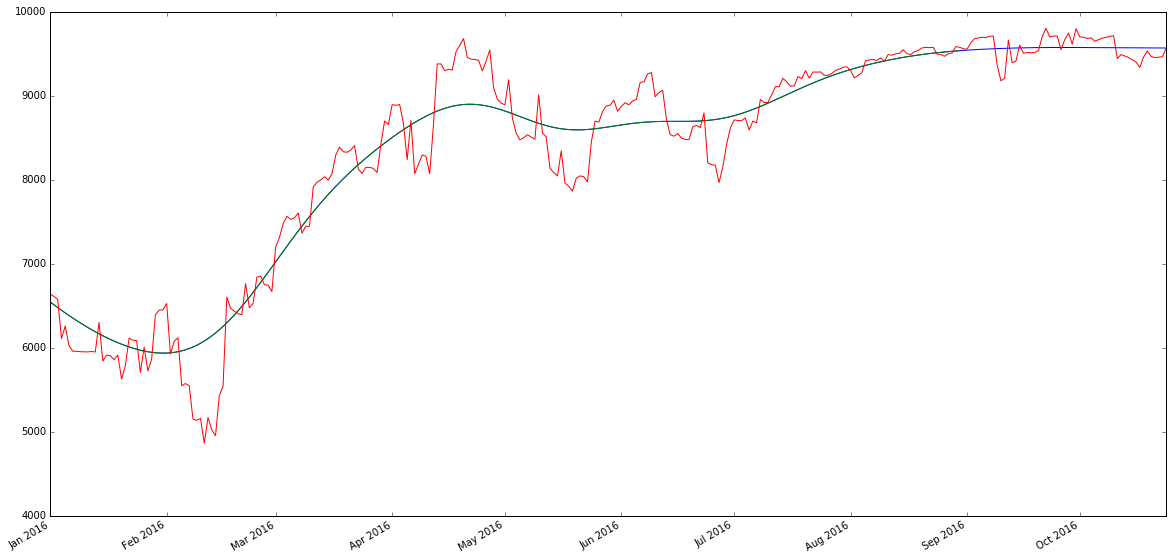

In [8]:
centered_ma = px_ser.rolling(100, center=True, win_type='blackmanharris').mean()
centered_ma[-1] = px_ser[-1]

centered_ma_trend = centered_ma.interpolate('cubic')

centered_ma_trend.ix['2016'].plot()

px_ser.rolling(100, center=True, win_type='blackmanharris').mean().ix['2016'].plot()
px_ser.ix['2016'].plot()

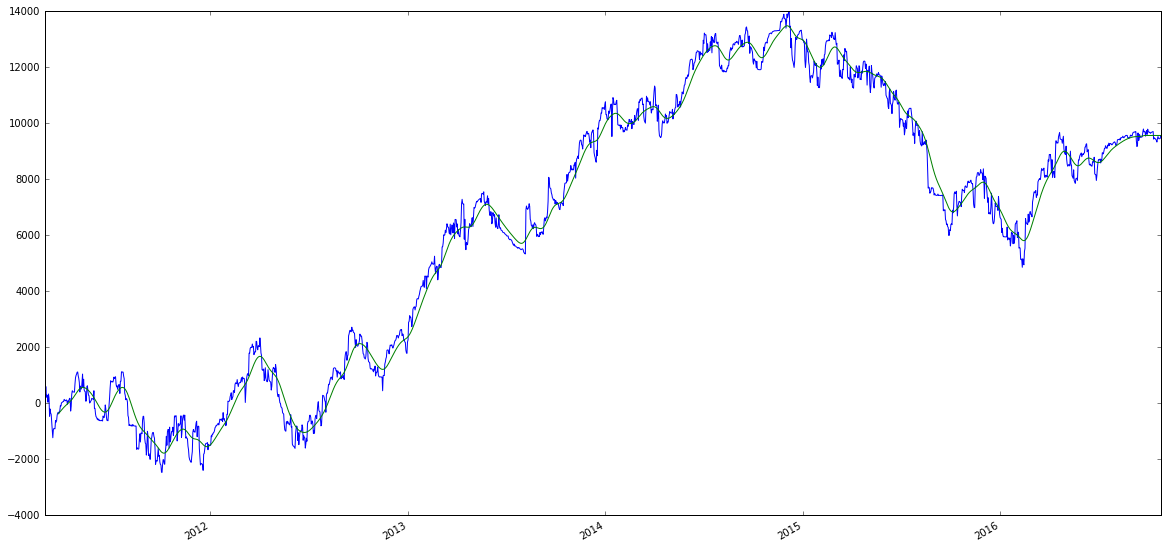

In [9]:
maema_trend = (px_ser.rolling(50, center=True, win_type='blackmanharris').mean().ewm(10).mean())

px_ser.plot()
maema_trend.plot()
#(px_ser - px_ser.ewm(30).mean()).plot()
#(px_ser - px_ser.shift(10)).plot()
#resid.plot()

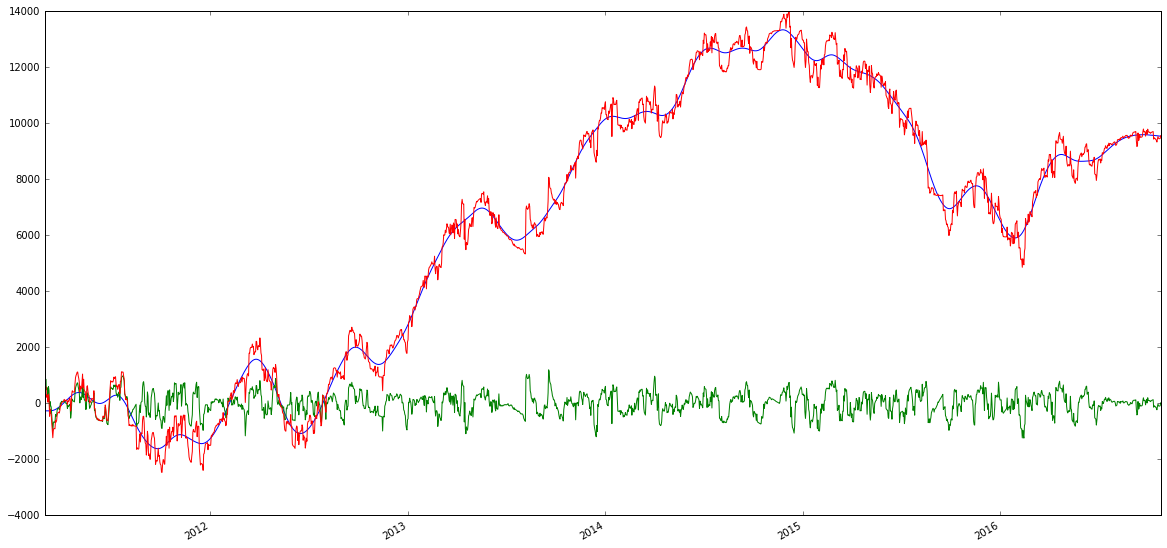

In [10]:
#smfilters.hp_filter.hpfilter(px_ser)[1]#.plot()
hpfilt = smfilters.api.hpfilter(px_ser, lamb=50000)[1]#.plot()

#smt.filters.
hpfilt.plot()

#resid.plot()
(px_ser - hpfilt).plot()
px_ser.plot()

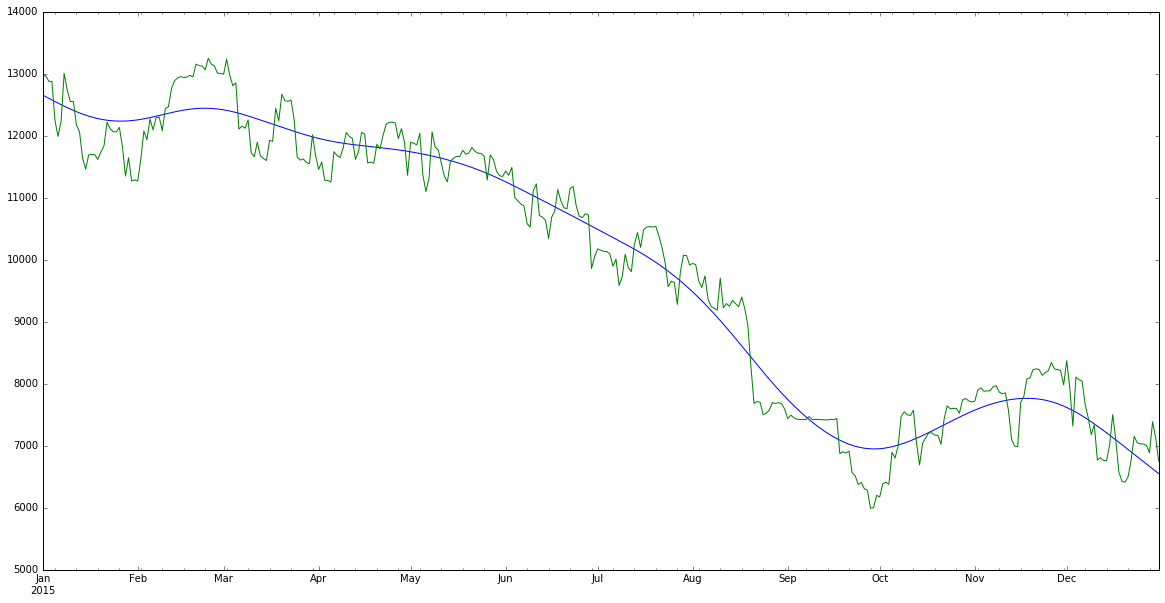

In [11]:
hpfilt.ix['2015'].plot()

px_ser.ix['2015'].plot()

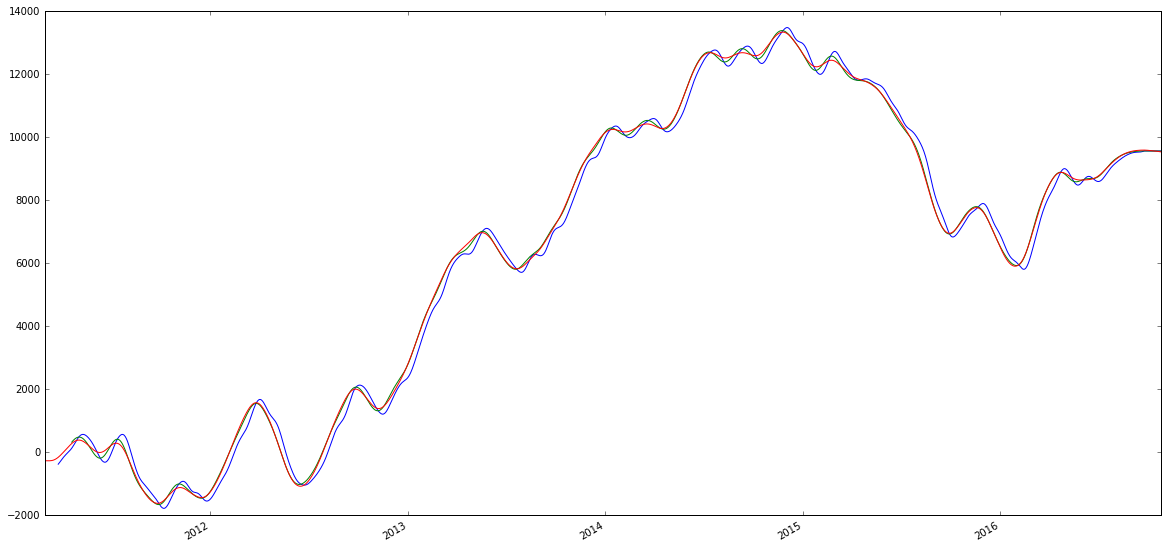

In [12]:
maema_trend.plot()

centered_ma_trend.plot()
hpfilt.plot()

In [13]:
#smfilters.hp_filter.hpfilter(px_ser)[1]#.plot()
cycle, trend = smfilters.bk_filter.bkfilter(px_ser, low=2, high=60)#.plot()

trend.plot()

#resid.plot()
#(px_ser - filt).plot()
px_ser.plot()

ValueError: too many values to unpack (expected 2)

In [14]:
smfilters.bk_filter.bkfilter(px_ser, low=2, high=60)

2011-03-13    -35.926790
2011-03-14   -326.190157
2011-03-15   -565.373769
2011-03-16   -798.140799
2011-03-17   -496.404038
2011-03-18   -429.511151
2011-03-19   -421.377235
2011-03-20   -427.820348
2011-03-21   -125.997856
2011-03-22   -182.764994
2011-03-23   -151.466085
2011-03-24     24.841619
2011-03-25     83.932328
2011-03-26     81.514126
2011-03-27     53.693393
2011-03-28    -19.500131
2011-03-29     19.104507
2011-03-30    153.938978
2011-03-31     96.105577
2011-04-01    169.916982
2011-04-02    148.910492
2011-04-03    132.501681
2011-04-04    116.698718
2011-04-05     88.503879
2011-04-06    158.016941
2011-04-07    124.691767
2011-04-08     74.181641
2011-04-09     49.510893
2011-04-10     48.672304
2011-04-11      2.631269
                 ...    
2016-09-07    169.893546
2016-09-08    169.835965
2016-09-09   -175.602887
2016-09-10   -378.247278
2016-09-11   -352.574424
2016-09-12     97.973700
2016-09-13   -175.748131
2016-09-14   -158.987035
2016-09-15     30.594301


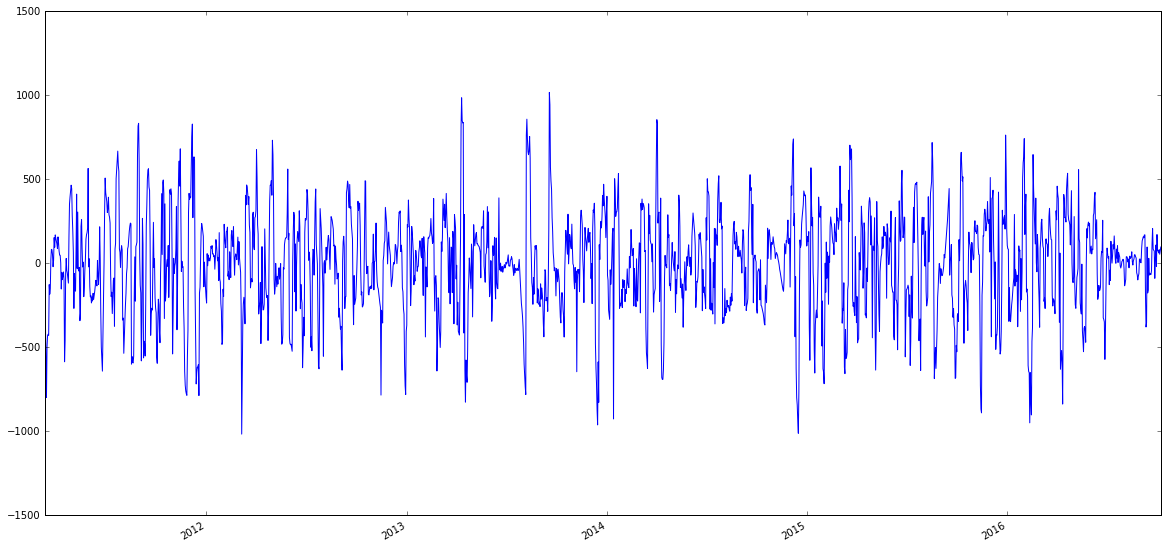

In [15]:
smfilters.bk_filter.bkfilter(px_ser, low=2, high=60).plot()

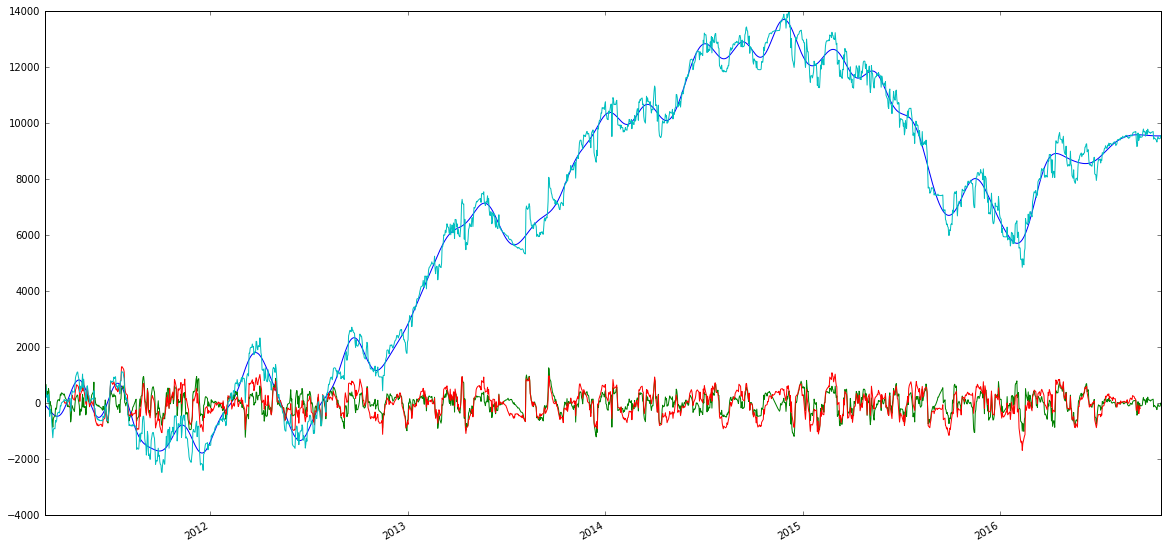

In [16]:
#smfilters.hp_filter.hpfilter(px_ser)[1]#.plot()
cycle, trend = smfilters.cf_filter.cffilter(px_ser, low=2, high=60, drift=False)#.plot()

trend.plot()
#trend.expanding().mean().plot()

cycle.plot()
resid.plot()
#(px_ser - filt).plot()
px_ser.plot()

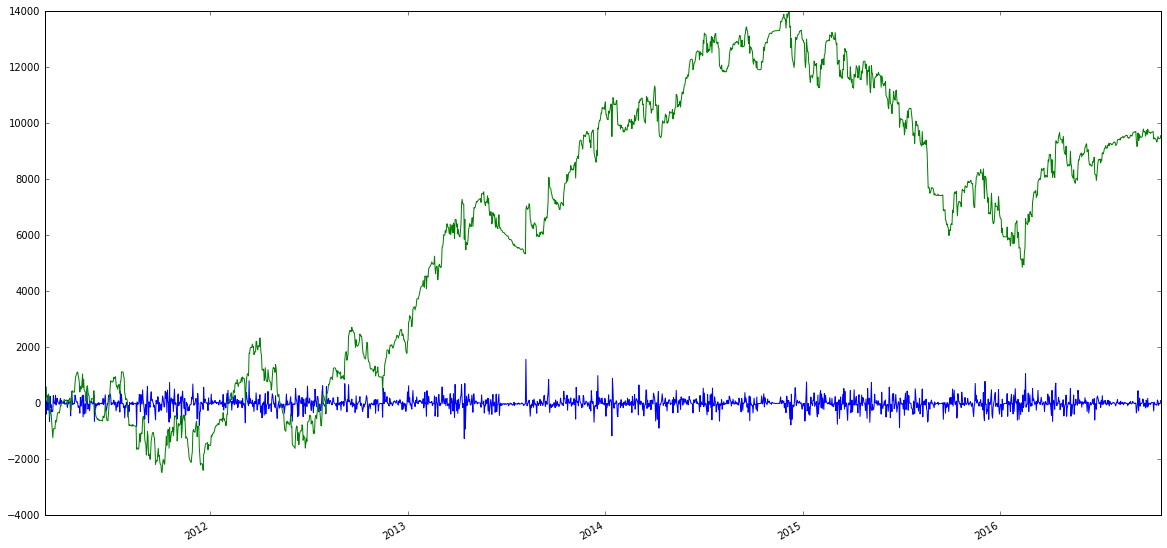

In [17]:
#resid.plot()
(px_ser - px_ser.shift(1)).plot()
px_ser.plot()
#axhline(0)

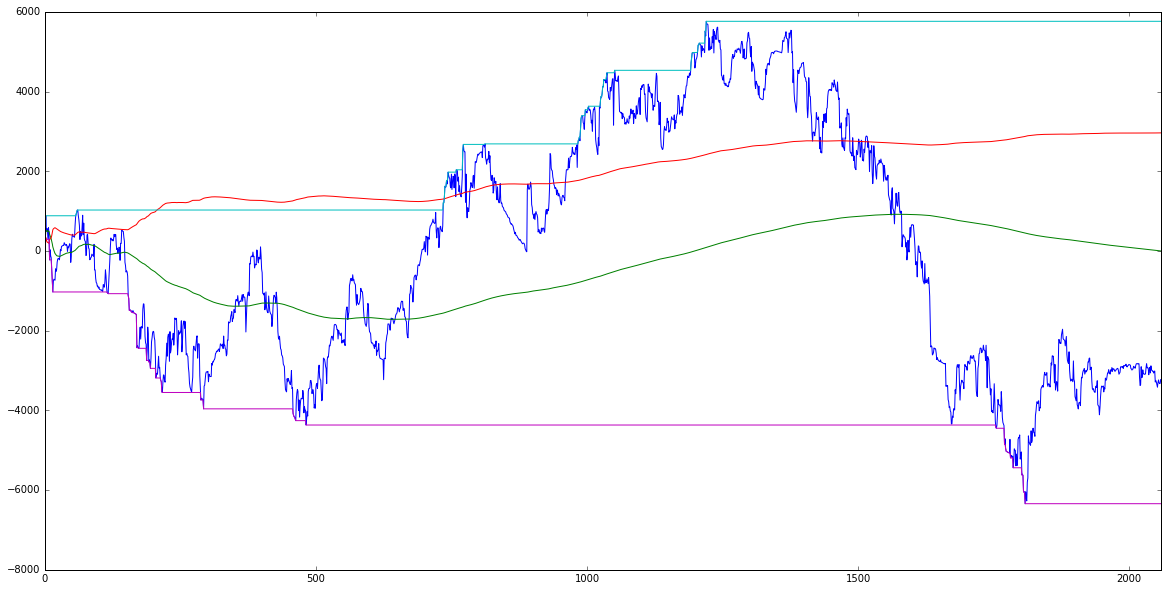

In [18]:
# Detrend func makes a px series pretty stationary
detrended_px = pd.Series(smt.tsatools.detrend(px_ser, order=1))
detrended_px.plot()
detrended_px.expanding().mean().plot()
detrended_px.expanding().std().plot()

detrended_px.expanding().max().plot()
detrended_px.expanding().min().plot()

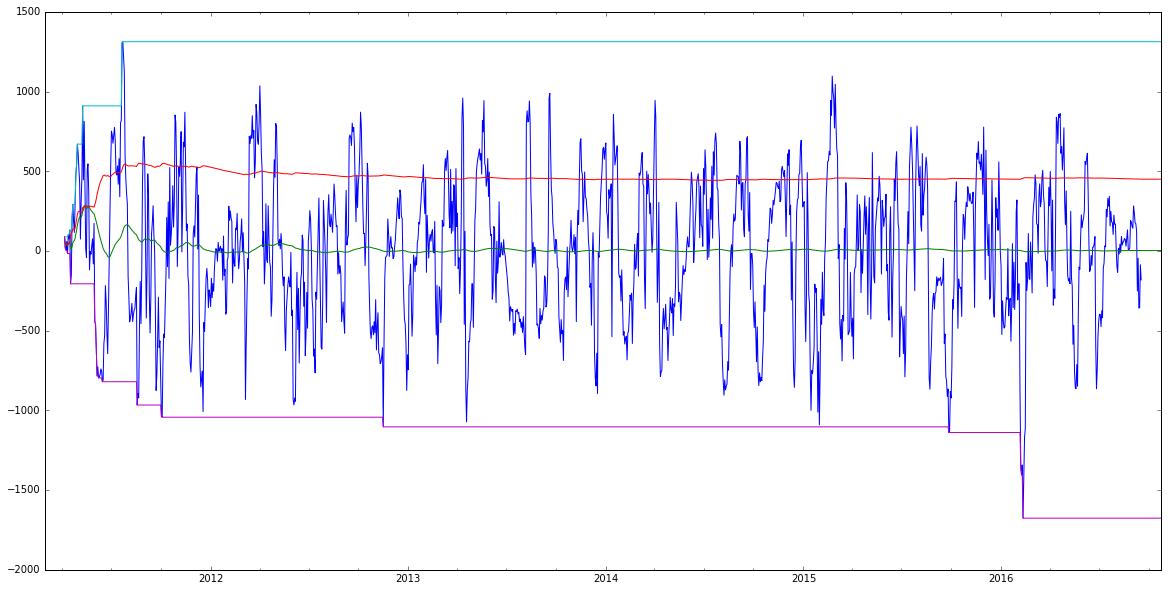

In [19]:
resid.plot()
resid.expanding().mean().plot()
resid.expanding().std().plot()

resid.expanding().max().plot()
resid.expanding().min().plot()

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



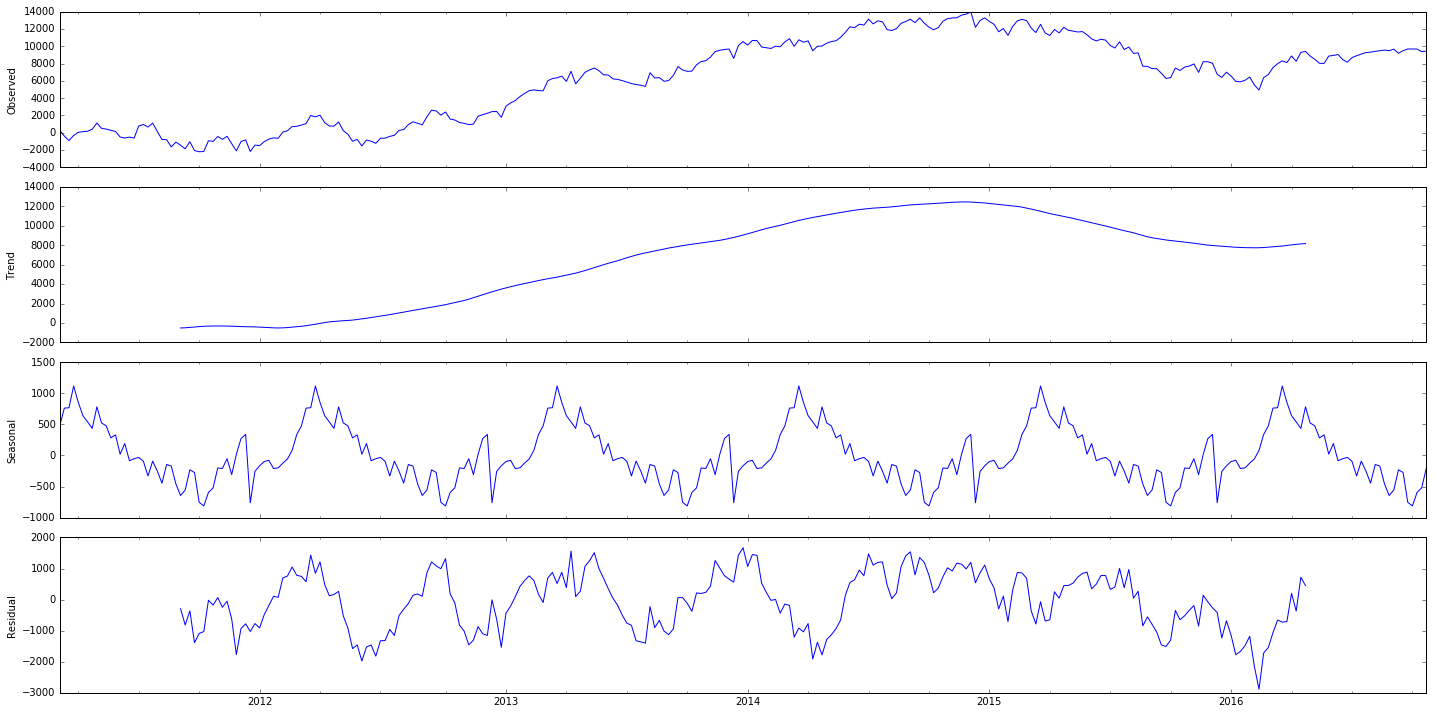

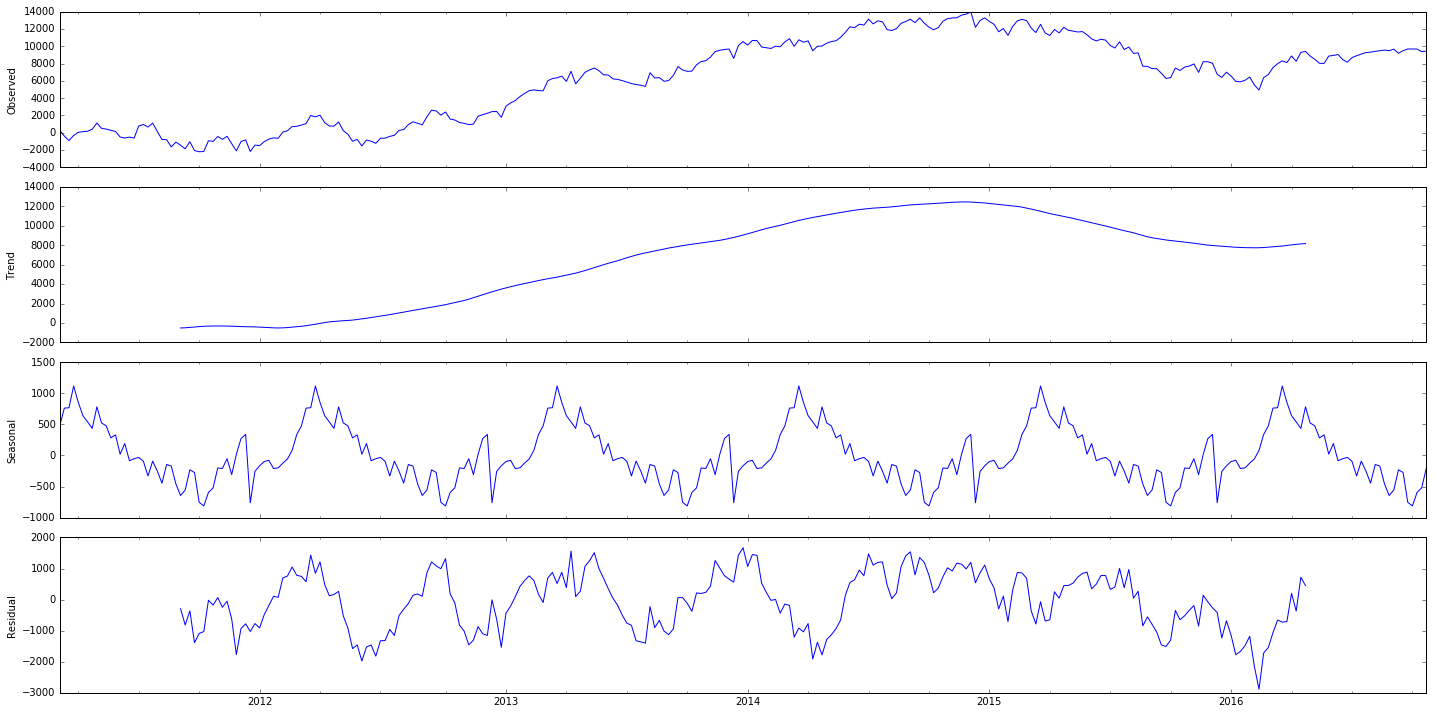

In [20]:
sd = smt.seasonal_decompose(px_ser.asfreq('W').ffill().dropna().iloc[:])#.plot()
sd.plot()

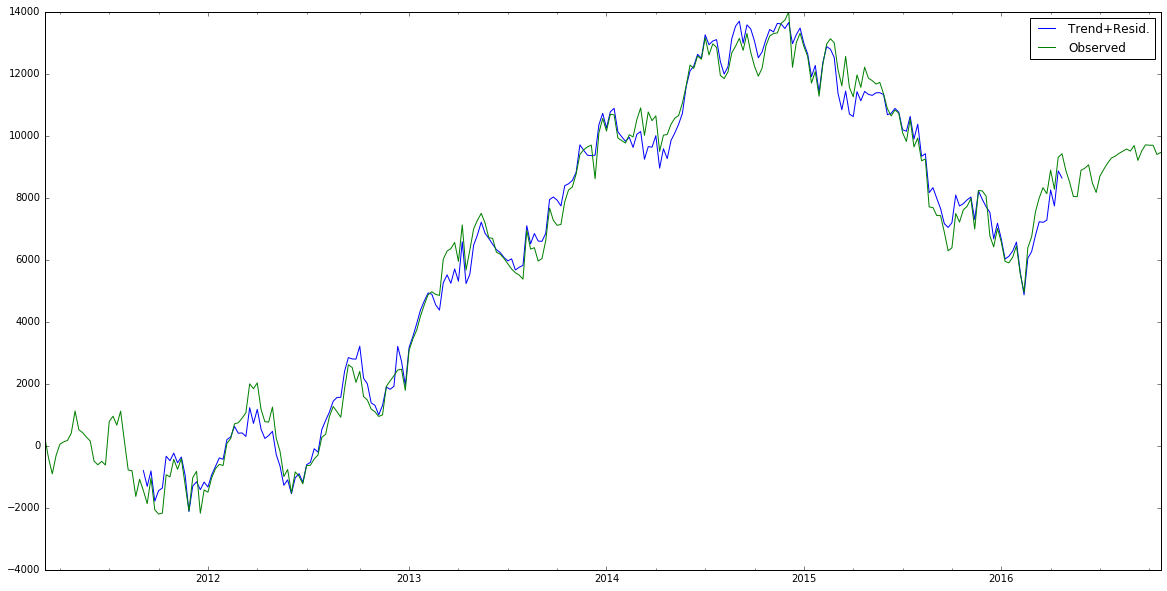

In [21]:
pd.Series((sd.trend + sd.resid), name='Trend+Resid.').plot(legend=True)
pd.Series((sd.observed), name='Observed').plot(legend=True)

# Entry Rules
# Exit rules - resid got back to 0, seasonal cycle got back to min/max
# Also Monthly or Weekly TF may be useful
# Resid is a detrended price series

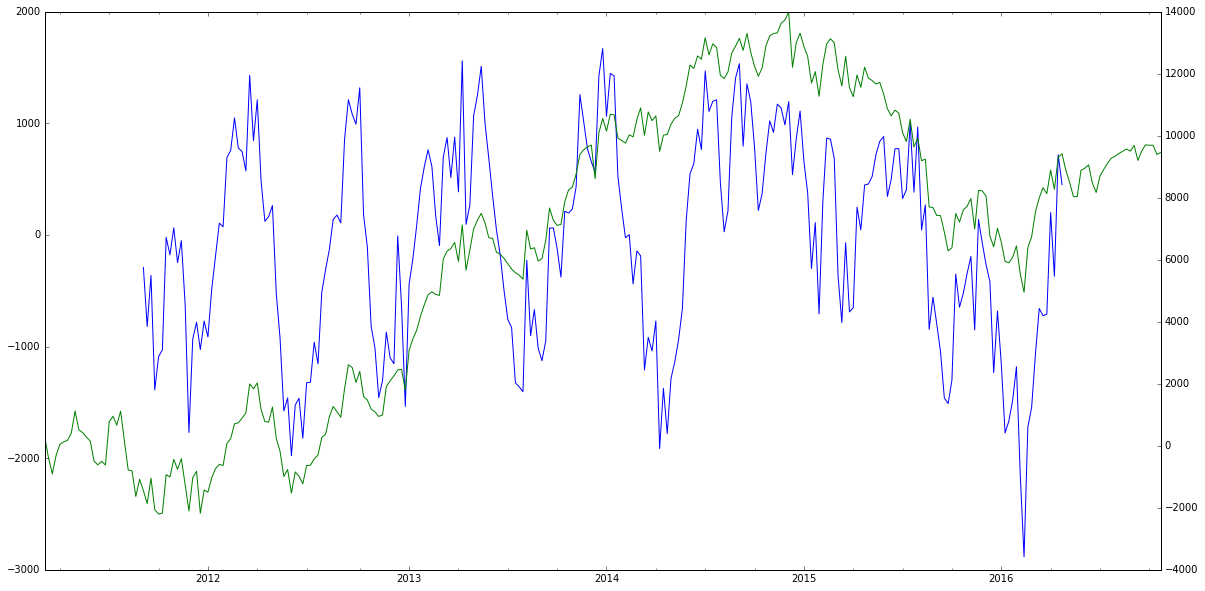

In [22]:
resid = sd.resid
seas = sd.seasonal

resid.plot()
sd.observed.plot(secondary_y=True)

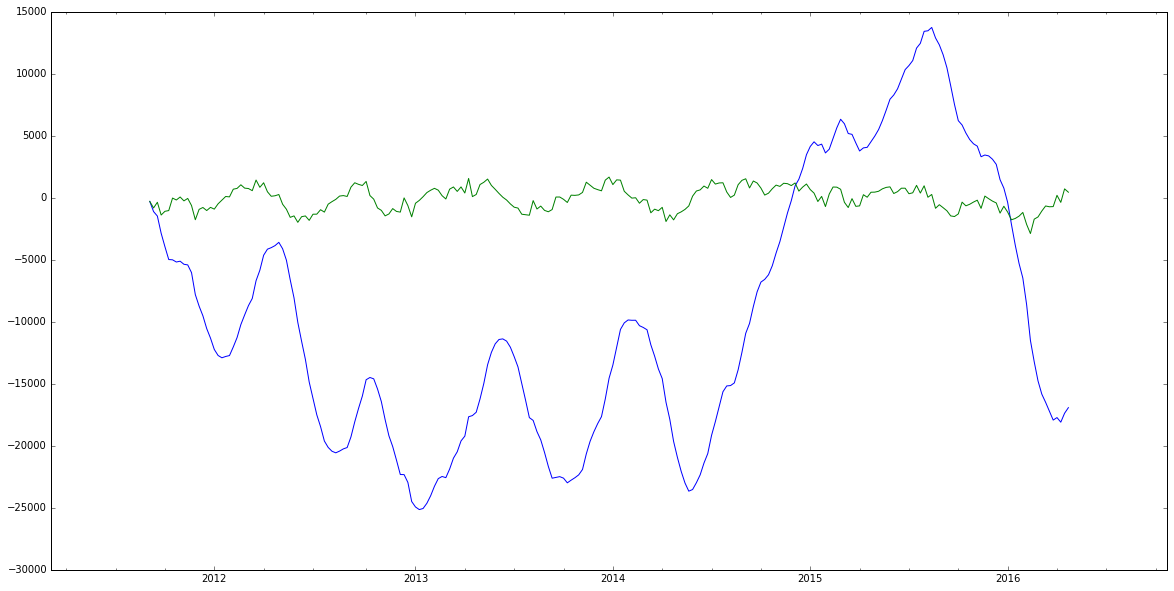

In [23]:
resid.cumsum().plot()
resid.plot()

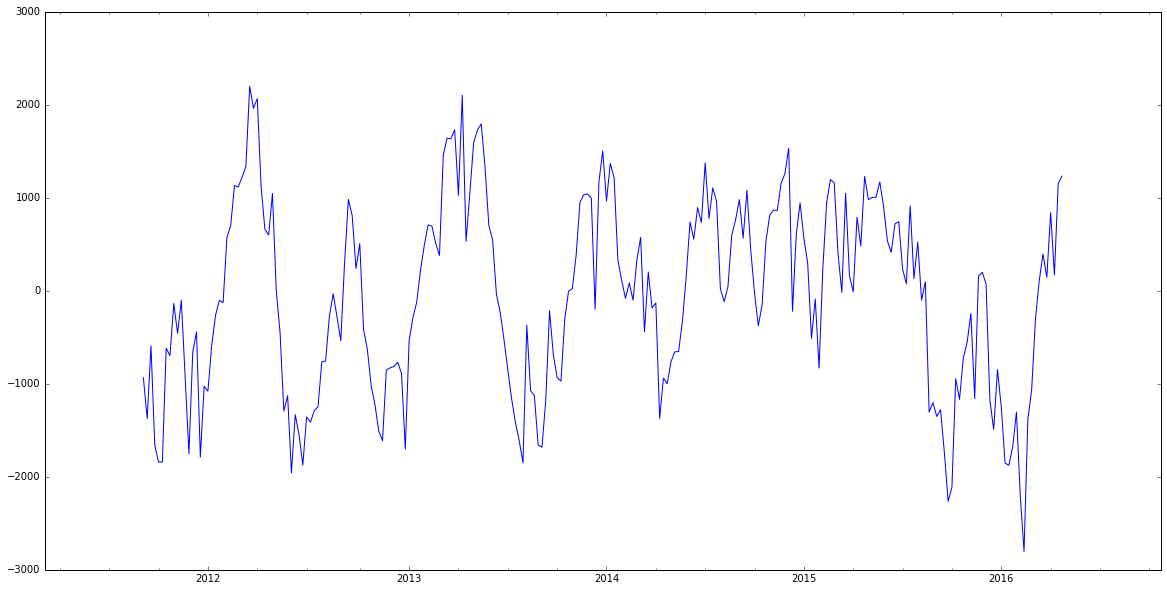

In [24]:
# Observed - Trend
(sd.observed - sd.trend).plot()

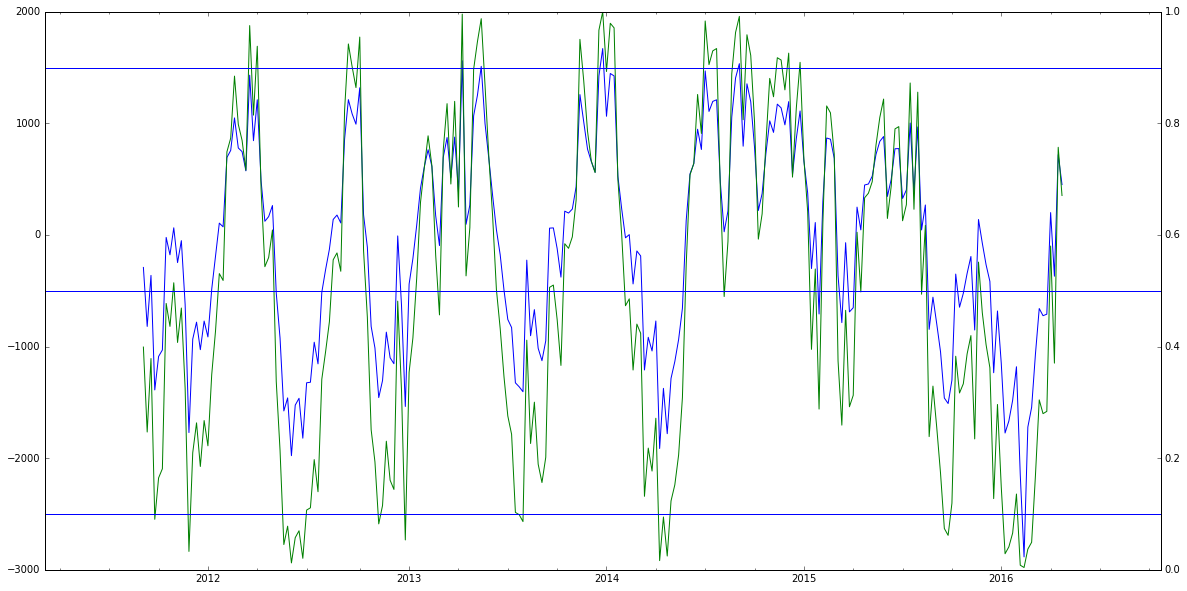

In [25]:
## Persent rank >= value or <= value
resid_pctrank = resid.rank(pct=True)

resid.plot()
resid_pctrank.plot(secondary_y=True)

axhline(0.5)
axhline(0.9)
axhline(0.1)

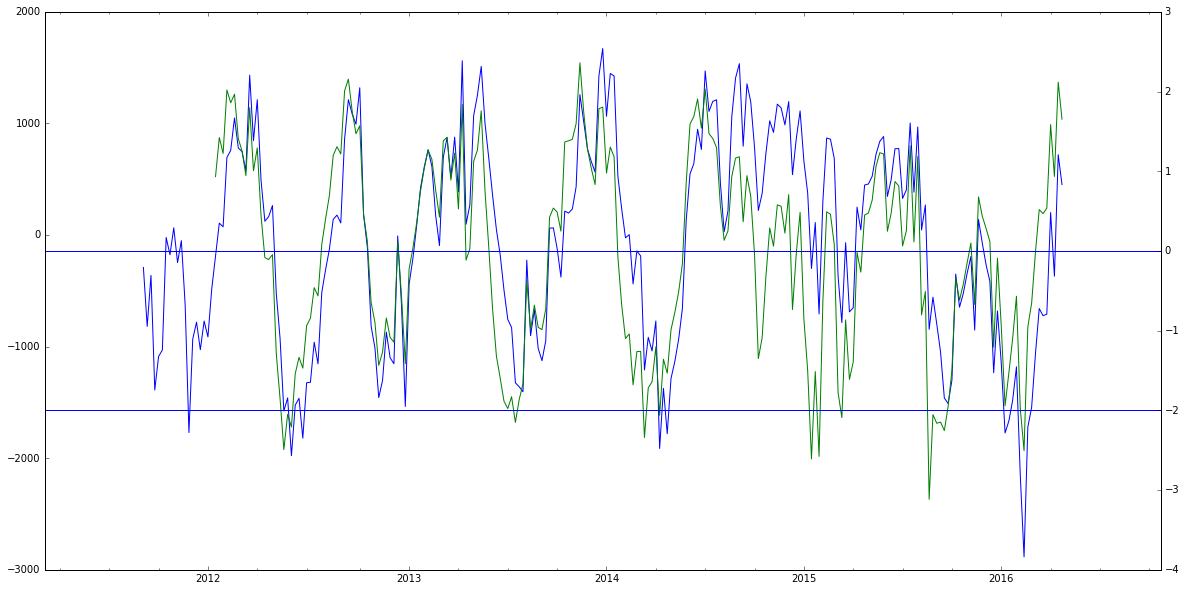

In [26]:
## Z Score >= value or <= value
# value, and period are subjects of optimization

resid_zscore = (resid - resid.rolling(20).mean()) / resid.rolling(20).std()

resid.plot()
resid_zscore.plot(secondary_y=True)

axhline(0)
axhline(3)
axhline(-2)

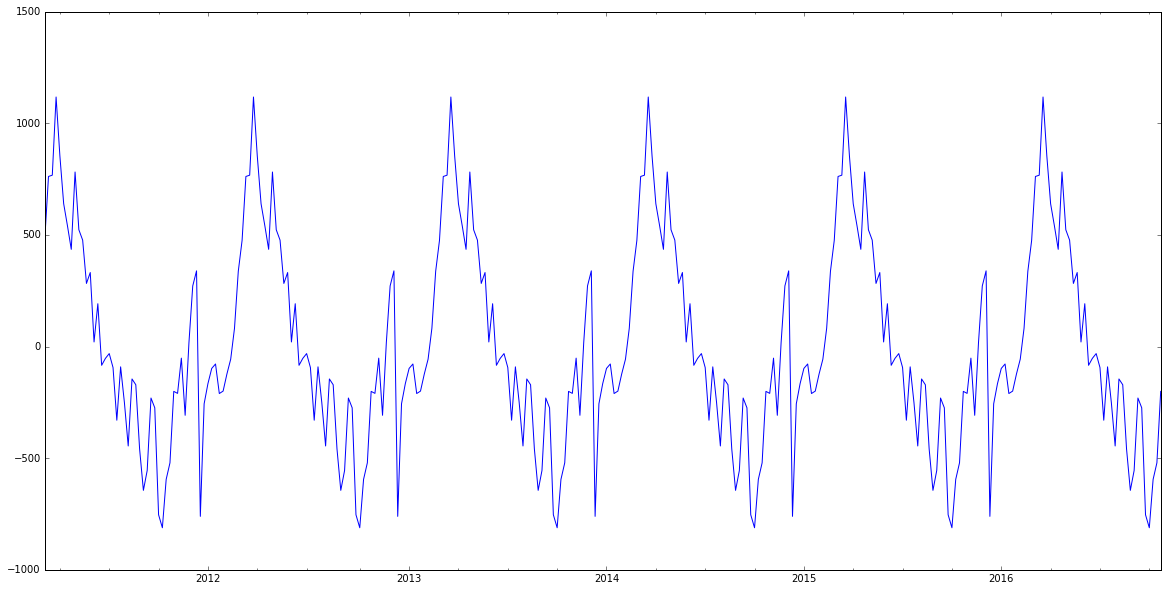

In [27]:
seas.plot()

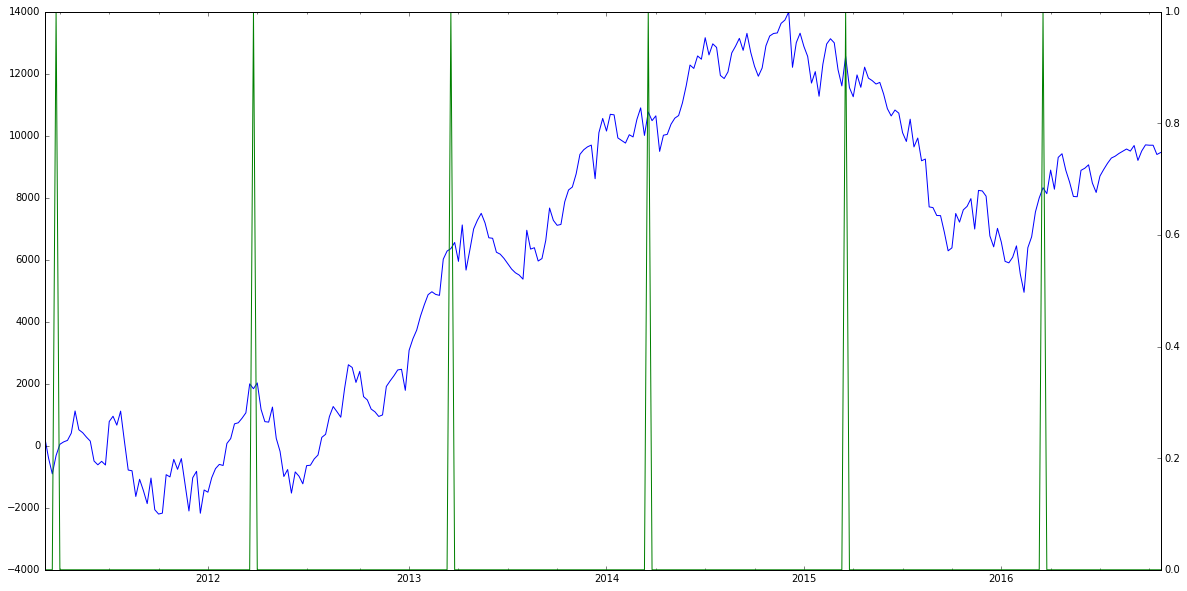

In [28]:
sd.observed.plot()
(seas == seas.max()).plot(secondary_y=True)

In [29]:
#df.join(pd.Series(seas == seas.max(), name='sig'))

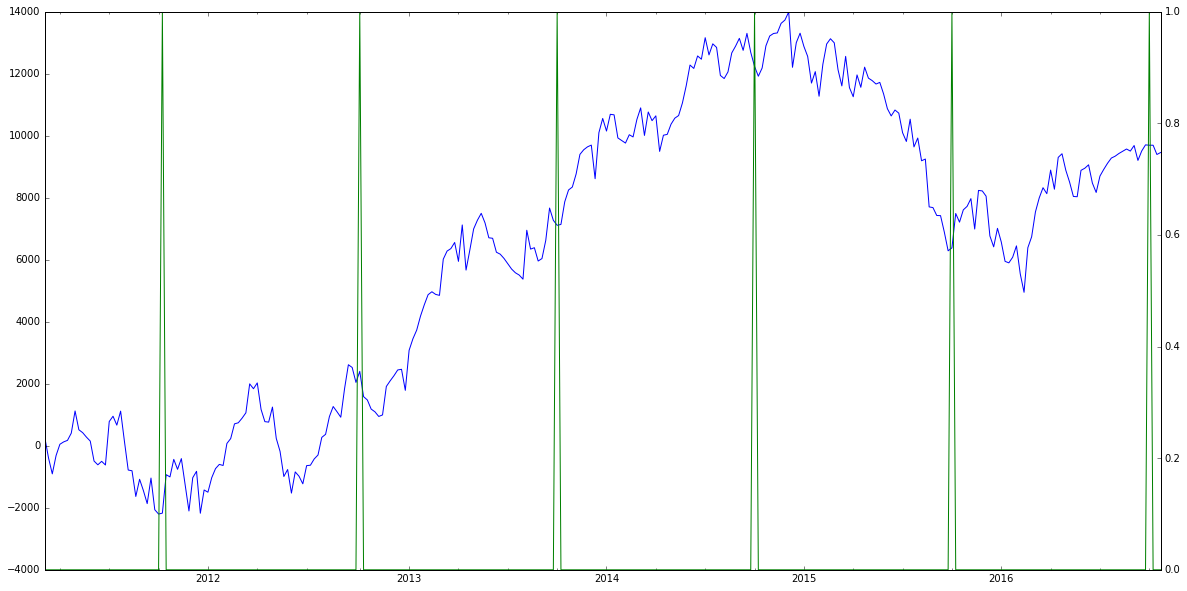

In [30]:
sd.observed.plot()
(seas == seas.min()).plot(secondary_y=True)
#((seas.shift(1) < 0) & ((seas >= 0))).plot(secondary_y=True)

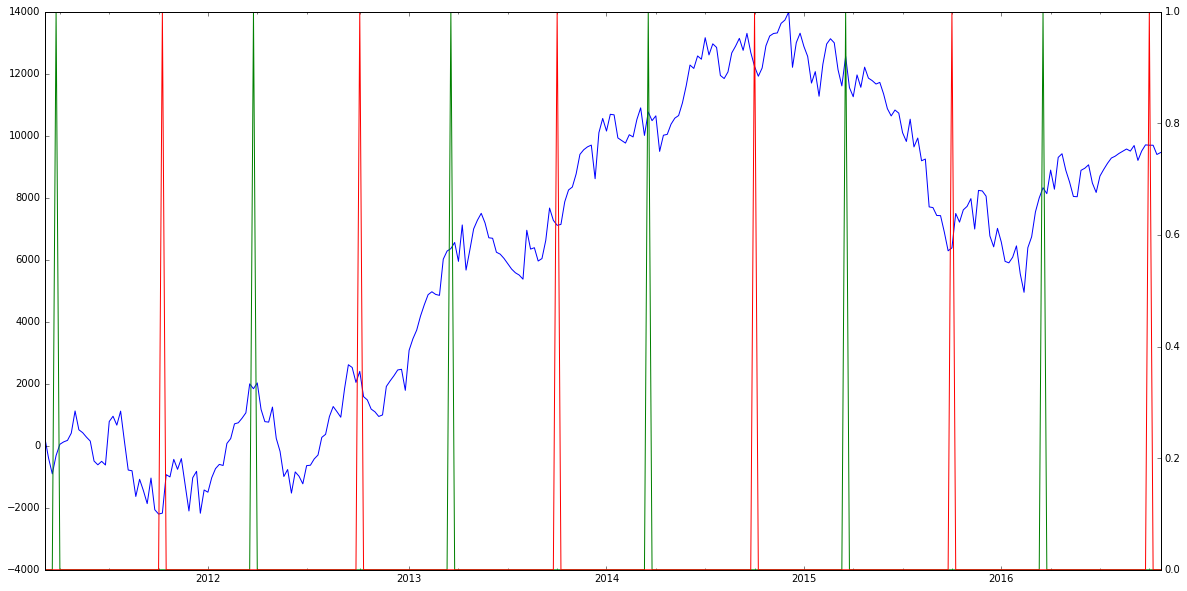

In [31]:
sd.observed.plot()
(seas == seas.max()).plot(secondary_y=True)
(seas == seas.min()).plot(secondary_y=True)


# Streaming























In [32]:
#py.sign_in('tmqr', '8rctfyu197')
py.sign_in('dmveden', 'rzbs7xw8ft')

tls.set_credentials_file(username='dmveden', api_key='rzbs7xw8ft')

In [33]:
stream_ids = tls.get_credentials_file()['stream_ids']
print(stream_ids)

[]


In [34]:
# Get stream id from stream id list 
stream_id1 = 'twfcm3v44s'
stream_id2 = '5dnfr3e5d8'
stream_id3 = '1ynb4ujpbt'

# Make instance of stream id object 
stream_1 = go.Stream(
    token=stream_id1,  # link stream id to 'token' key
    maxpoints=200      # keep a max of 80 pts on screen
)

# Make instance of stream id object 
stream_2 = go.Stream(
    token=stream_id2,  # link stream id to 'token' key
    maxpoints=200      # keep a max of 80 pts on screen
)

# Make instance of stream id object 
stream_3 = go.Stream(
    token=stream_id3,  # link stream id to 'token' key
    maxpoints=200      # keep a max of 80 pts on screen
)

# Initialize trace of streaming plot by embedding the unique stream_id
trace1 = go.Scatter(
    x=[],
    y=[],
    mode='lines+markers',
    stream=stream_1         # (!) embed stream id, 1 per trace
)

trace1 = go.Scatter(x=[], y=[], stream=stream_1, name='Fixed_filter')
trace2 = go.Scatter(x=[], y=[], stream=stream_2, name='Price', marker=dict(color='rgb(148, 103, 189)'))
trace3 = go.Scatter(x=[], y=[], stream=stream_3, name='Standard filter', marker=dict(color='rgb(255, 0, 0'))

data = go.Data([trace1, trace2, trace3])

# Add title to layout object
layout = go.Layout(title='Hodrick Prescott Filter Calculation Process')

# Make a figure object
fig = go.Figure(data=data, layout=layout)

# Send fig to Plotly, initialize streaming plot, open new tab
py.iplot(fig, filename='python-streaming')

In [35]:
# We will provide the stream link object the same token that's associated with the trace we wish to stream to
s_1 = py.Stream(stream_id=stream_id1)
s_2 = py.Stream(stream_id=stream_id2)
s_3 = py.Stream(stream_id=stream_id3)

# We then open a connection
s_1.open()
s_2.open()
s_3.open()

In [ ]:
# (*) Import module keep track and format current time
import datetime 
import time   
 
i = 10   # a counter
k = 5    # some shape parameter

# Delay start of stream by 5 sec (time to switch tabs)
#time.sleep(2) 

#hpfilt = smfilters.api.hpfilter(px_ser, lamb=50000)[1]#.plot()
#resid = (px_ser - hpfilt)
fixed_hpfilt = pd.Series(NaN, index=px_ser.index)
first_time_calc_flag = True

while True:
    if i > px_ser.size:
        break
        
    hpfilt = smfilters.api.hpfilter(px_ser.iloc[:i], lamb=50000)[1]#.plot()
    #filt = smfilters.cf_filter.cffilter(px_ser.iloc[:i], low=2, high=60, drift=False)[1]
    #hpfilt = px_ser.iloc[:i].rolling(30, center=True).mean()
    #filt[-1] = px_ser.iloc[:i][-1]
    #filt.interpolate(inplace=True)
    
    
     
    hpfilt_slice = smfilters.api.hpfilter(px_ser.iloc[:i], lamb=50000)[1]
    fixed_hpfilt.iloc[i] = np.mean(hpfilt_slice[-1:])
    
    filt = fixed_hpfilt
    
    # Current time on x-axis, random numbers on y-axis
    x_1 = filt.iloc[:i].index
    y_1 = filt.iloc[:i]
     
    x_2 = px_ser.iloc[:i].index
    y_2 = px_ser.iloc[:i] 
    
    x_3 = hpfilt.iloc[:i].index
    y_3 = hpfilt.iloc[:i] 
    
    # Send data to your plot
    s_1.write(dict(x=x_1, y=y_1))  
    s_1.write(dict(x=x_1, y=y_1)) 
    
    s_2.write(dict(x=x_2, y=y_2))  
    s_2.write(dict(x=x_2, y=y_2)) 
    
    s_3.write(dict(x=x_3, y=y_3))  
    s_3.write(dict(x=x_3, y=y_3)) 
    #     Write numbers to stream to append current data on plot,
    #     write lists to overwrite existing data on plot
            
    time.sleep(0.1)  # plot a point every second    
    i += 1
    
   
# Close the stream when done plotting
s_1.close() 
s_2.close() 

In [ ]:
hpfilt = smfilters.api.hpfilter(px_ser, lamb=50000)[0]

def x():
    fixed_hpfilt = pd.Series(NaN, index=px_ser.index)

    window = 10
    first_time_calc_flag = True

    for i in range(window, len(px_ser)):
        hpfilt_slice = smfilters.api.hpfilter(px_ser.iloc[:i], lamb=50000)[0]
        fixed_hpfilt.iloc[i] = np.mean(hpfilt_slice[-1:])
        
    return fixed_hpfilt

In [ ]:
%timeit x()

In [ ]:
px_ser.ix[:].plot()
#px_ser.rolling(100).std().ix["2011":].plot()
#hpfilt.ix['2011':].plot()
fixed_hpfilt.plot()
fixedfilter_resid.plot()

In [ ]:
fixedfilter_resid = px_ser - fixed_hpfilt

fixedfilter_resid.plot()
fixedfilter_resid.expanding().mean().plot()
fixedfilter_resid.expanding().std().plot()

fixedfilter_resid.expanding().max().plot()
fixedfilter_resid.expanding().min().plot()

In [ ]:
hpfilt_resid = px_ser - hpfilt

hpfilt_resid.plot()
hpfilt_resid.expanding().mean().plot()
hpfilt_resid.expanding().std().plot()

hpfilt_resid.expanding().max().plot()
hpfilt_resid.expanding().min().plot()

In [ ]:
hpfilt_resid.plot()
fixedfilter_resid.plot()

In [ ]:
(fixedfilter_resid - hpfilt_resid).plot()